# Labolatorium 8

## Page Rank

---
### Przydatne importy

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

W rozwiązaniu zadania będę wspomagał się bibliotekami zewnętrznymi:
 * `numpy` w wersji *1.18.4* - szybkie obliczenia i funkcje pomocnicze - [docs](https://docs.scipy.org/doc/numpy/)
 * `networkx` w wersji *2.4* - struktury i operacje na grafach - [docs](https://networkx.github.io/documentation/stable/)
 * `matplotlib` w wersji *3.2.1* - wizualizacja wyników i progresu - [docs](https://matplotlib.org/#documentation)

---
### Zadanie 1 Prosty ranking wierzchołków

Zaimplementuj prosty model błądzenia przypadkowego po grafie skierowanym:
<h3><div align="center">$r(u) = d \sum_{v \in B_u} \frac{r(v)}{N_v}$, </div></h3>
gdzie $r(u)$ oznacza ranking wierzchołka $u$, parametr $c$ (chyba powinno być $d$?) jest używany w normalizacji, $B_u$ jest zbiorem wierzchołków, do których dochodzą krawędzie z wierzchołka $v$, $F_v$ oznacza zbiór wierzchołków, do których dochodzą krawędzie z wierzchołka $v$, a $N_v = |F_v|$. W zapisie macierzowym:
<h3><div align="center">$ r = dAr, $ </div></h3>
gdzie $A$ jest macierzą adjacencji grafu, w której każdy wierzu $u$ jest przeskalowany wyjściowym stopniem wierzchołka $u$.


<h3><div align="center">$A_{u,v} = \begin{cases} \frac{1}{N_u} &\text{jeśli krawędź $(u,v)$ istnieje} \\ 0             &\text{w przeciwnym wypadku} \end{cases} $</div></h3>


Zauważ, że **r** może zostać obliczony jako dominujący wektor własny macierzy **A** za pomocą metody potęgowej (dominujący wektor własny $q_1$ znormalizowany za pomocą normy $L1$). Przetestuj poprawność obliczen korzystając z 3 dowolnych silnie spójnych grafów skierowanych o liczbie wierzchołków większej niż 10.

W pierwszej kolejności stworzymy sobie generator grafów skierowanych:

In [5]:
def generate_strongly_connected_graph(n=10, edge_probability=0.5):
    G = nx.gnp_random_graph(n, edge_probability, directed=True)
    while not nx.is_strongly_connected(G):
        G = nx.gnp_random_graph(n, edge_probability, directed=True)
    return G

Wygenerujmy trzy grafy *G_1, G_2, G_3* o liczbie wierzchołków odpowiednio *15, 20, 30* i sprawdźmy czy zostały one wygenerowane poprawnie:

In [116]:
G_1 = generate_strongly_connected_graph(15)
G_2 = generate_strongly_connected_graph(20)
G_3 = generate_strongly_connected_graph(30)

In [117]:
print(list(nx.strongly_connected_components(G_1)))
print(list(nx.strongly_connected_components(G_2)))
print(list(nx.strongly_connected_components(G_3)))

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}]
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}]
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}]


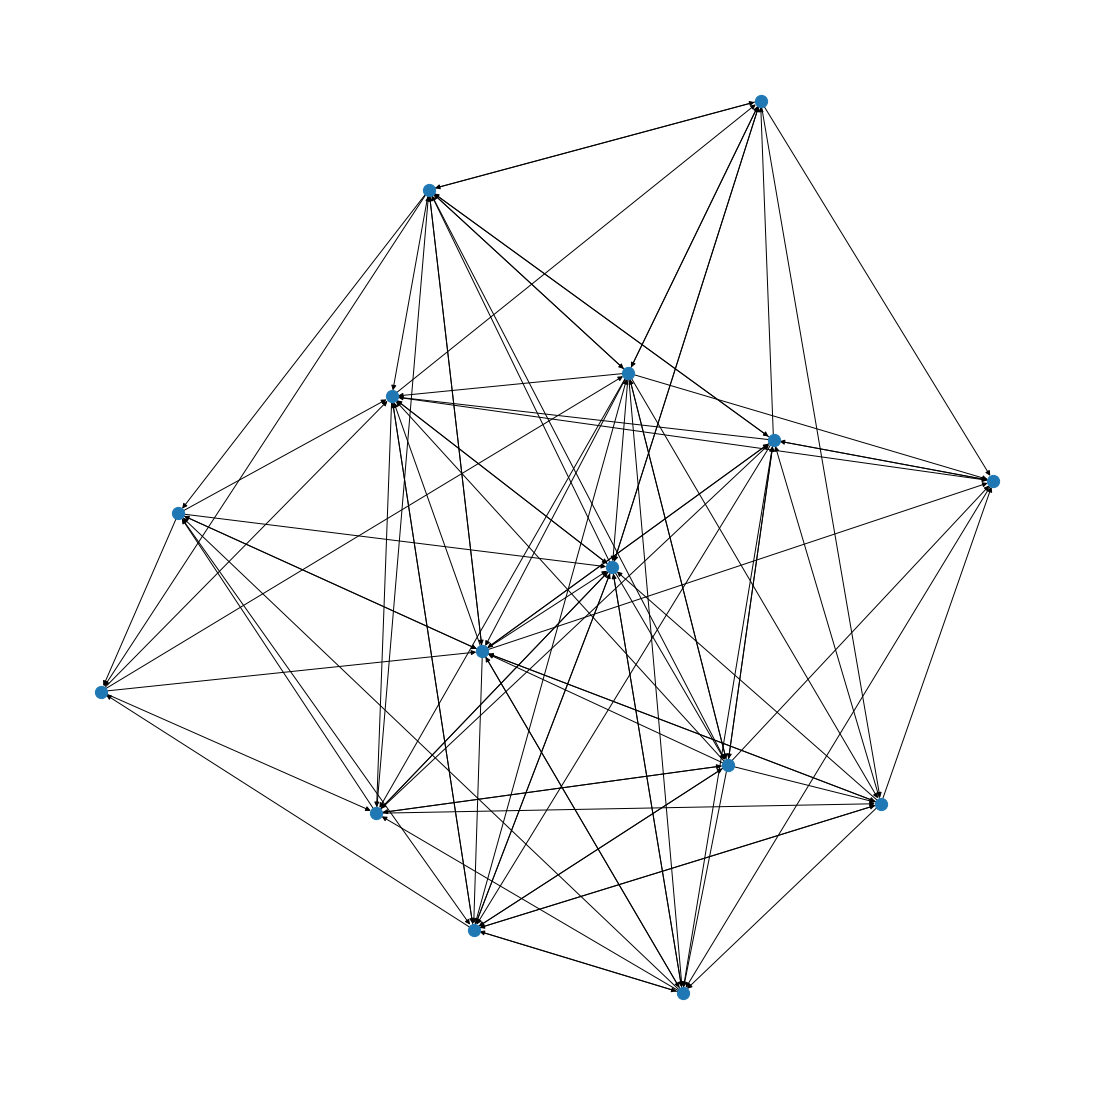

In [118]:
plt.figure(1, figsize=(15, 15))
position = nx.kamada_kawai_layout(G_1)
nx.draw(G_1, position, node_size=150)

Mając już wygenerowane grafy testowe, możemy przystąpić do rozwiązywania zadania. Postaram się skorzystać macierzowej funkcji **r**:
<h3><div align="center">$ r = dAr, $ </div></h3>
gdzie $A$ jest macierzą adjacencji grafu, w której każdy wierzu $u$ jest przeskalowany wyjściowym stopniem wierzchołka $u$.


<h3><div align="center">$A_{u,v} = \begin{cases} \frac{1}{N_u} &\text{jeśli krawędź $(u,v)$ istnieje} \\ 0             &\text{w przeciwnym wypadku} \end{cases} $</div></h3>

Zacznę od funkcji która przyjmuje graph i zwraca dla niego macierz $A$.

In [164]:
def get_scaled_adjacency_matrix(G):
    A = nx.to_numpy_matrix(G)
    N_u = np.sum(A, axis=1)
    scaled_A = A / np.where(N_u == 0.0, 1.0, N_u)
    return(scaled_A)

In [165]:
get_scaled_adjacency_matrix(G_1)

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.5       , 0.5       , 0.        , 0.        ],
        [0.2       , 0.        , 0.        , 0.2       , 0.        ,
         0.2       , 0.2       , 0.        , 0.2       , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.2       ,
         0.        , 0.        , 0.2       , 0.2       , 0.2       ,
         0.2       , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.125     , 0.125     , 0.        , 0.        ,
         0.        , 0.125     , 0.125     , 0.        , 0.125     ,
         0.125     , 0.125     , 0.        , 0.        , 0.125     ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.        ,
         0.14285714, 0.       

Następnie postaram się stworzyć funkcję, na wejściu przyjmuje macierz **A** i metodą potęgową oblicza jej wektor własny znormalizowany za pomocą normy *L1*. Wspomogę się własną implementacją z poprzedniego labolatorium.

In [166]:
def power_method(matrix, max_iterations=100000,  eps=10**(-12)):
    n = matrix.shape[0]
    x = np.random.uniform(size=(n, 1))
    x /= np.linalg.norm(x, ord=1)

    for k in range(max_iterations):
        y = matrix @ x
        y /= np.linalg.norm(y, ord=1)
        
        if np.linalg.norm(x - y, ord=1) < eps:
            return y

        x = y
    
    return x

Wreszcie stworzę funkcję, która przyjmuje graf i korzystając z obu powyższych funkcji, zwraca wektor **r**:

In [167]:
def get_simple_rank(graph):
    A = get_scaled_adjacency_matrix(graph)
    return power_method(A)

In [168]:
r_1 = get_simple_rank(G_1)
r_2 = get_simple_rank(G_2)
r_3 = get_simple_rank(G_3)

Sprawdźmy czy obliczenia zostały wykonane poprawnie

In [169]:
print(np.linalg.norm(r_1, ord=1))
print(np.linalg.norm(r_2, ord=1))
print(np.linalg.norm(r_3, ord=1))

1.0
1.0
0.9999999999999999


Jak widać $||r||_1 = 1$ zatem można założyć, że obliczenia dla tych trzech grafów zostały wykonane poprawnie.

---
### Zadanie 3 Page Rank

Rozszerz model z poprzedniego zadania, dodając możliwość skoku do losowego wierzchołka grafu:
<h3><div align="center">$r(u) = d \sum_{v \in B_u} \frac{r(v)}{N_v} + (1 - d)\cdot e(u)$, </div></h3>

W zapisie macierzowym:
<h3><div align="center">$ r = dAr + (1 - d)e\otimes 1, $ </div></h3>
gdzie $||r||_1 = 1$, a $e$ jest wektorem zawierającym prawdopodobieństwo odwiedzania wierzchołków przez losowy skok. Wykorzystaj metodę potęgową do obliczenia Page Rank jako dominującego wektora własnego macierz $B = dA + (1-d)e\otimes 1$.

Najpierw przygotujmy sobie dane testowe. Skorzystamy z grafów *G_1, G_2, G_3* z poprzedniego podpunktu.

In [170]:
D = np.array([0.9, 0.85, 0.75, 0.6, 0.5])

def get_E(G):
    n = len(G)
    e_1 = np.ones(shape=(n,1))/n
    e_2 = np.random.uniform(size=(n,1))
    e_2 = e_2/np.sum(e_2)
    e_3 = np.ones(shape=(n,1))/(2*n)
    e_3[0] += 0.5
    return np.array([e_1, e_2, e_3])

E_1 = get_E(G_1)

In [171]:
print(E_1[0])
print(E_1[1])
print(E_1[2])

[[0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]
 [0.06666667]]
[[0.06703599]
 [0.07659069]
 [0.0834618 ]
 [0.10739018]
 [0.03325978]
 [0.06862025]
 [0.03244524]
 [0.02005566]
 [0.09997552]
 [0.09551068]
 [0.07868756]
 [0.03185226]
 [0.05950719]
 [0.06228968]
 [0.08331753]]
[[0.53333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]
 [0.03333333]]


Teraz zmodyfikuję metodę potęgową, zgodnie z zaleconym algorytmem tak, aby uwzględniała możliwość skoku do losowego wierzchołka grafu.

In [176]:
def power_method(matrix, e, d=0.5, max_iterations=100,  eps=10**(-12)):
    n = matrix.shape[0]
    B = d*matrix + (1-d)*(e * np.identity(n))
    r = np.random.uniform(size=(n, 1))
    r /= np.linalg.norm(r, ord=1)

    for k in range(max_iterations):
        y = B @ r
        y /= np.linalg.norm(y, ord=1)
        
        d = np.linalg.norm(r) - np.linalg.norm(y)

        y += d*e
        sigma = np.linalg.norm(y - r, ord=1)
        
        if sigma < eps:
            return y

        r = y
    
    return r

Poniższa funkcja będzie służyła do przetestowania page rank dla danego grafu, używając różnych wartości $d$ oraz $e$ 

In [177]:
import time

In [178]:
def test_extended_page_rank(G):
    E = get_E(G)
    
    for (index, e) in enumerate(E):
        for d in D:        
            start = time.time()
            A = get_scaled_adjacency_matrix(G)
            r = power_method(A, e, d)
            stop = time.time()
            print("\n------------------")
            print(f"d = {d}, e_{index}")
            print(f"||r||_1 = {np.linalg.norm(r, 1)}")
            print(f"Max rank = {np.max(r)}, index = {np.argmax(r)}")
            print(f"Algorithm took {stop - start}s to complete")

In [179]:
print("\n===================== G_1 =====================")
test_extended_page_rank(G_1)
print("\n===================== G_2 =====================")
test_extended_page_rank(G_2)
print("\n===================== G_3 =====================")
test_extended_page_rank(G_3)


===================== G_1 =====================

------------------
d = 0.9, e_0
||r||_1 = 1.0000000000000018
Max rank = 0.06666666666668253, index = 1
Algorithm took 0.002532482147216797s to complete

------------------
d = 0.85, e_0
||r||_1 = 1.0000000000000058
Max rank = 0.06666666666669169, index = 4
Algorithm took 0.00244903564453125s to complete

------------------
d = 0.75, e_0
||r||_1 = 1.0000000000000022
Max rank = 0.06666666666669015, index = 12
Algorithm took 0.002810239791870117s to complete

------------------
d = 0.6, e_0
||r||_1 = 1.0000000000000056
Max rank = 0.06666666666671071, index = 3
Algorithm took 0.0026297569274902344s to complete

------------------
d = 0.5, e_0
||r||_1 = 1.0000000000000044
Max rank = 0.06666666666669806, index = 12
Algorithm took 0.0021784305572509766s to complete

------------------
d = 0.9, e_1
||r||_1 = 1.000000000000001
Max rank = 0.06720206146111943, index = 2
Algorithm took 0.002193927764892578s to complete

------------------
d = 0.85,

---
### Interpretacja wyników

W $e_0$ mamy równomierny rozkład prawdopodobieństwa, co sprawia, że wszystkie wierzchołki powinny mieć +- taki sam ranking. Potwierdza to fakt, że wierzchołek z największym rankingiem ma dość losowy indeks i ranking zawsze bardzo bliski liczbie $\frac{1}{n}$.

W $e_1$ mamy zupełnie losowy rozkład prawdopodobieństwa, widać jednak, że od niego zależy mocno wektor wynikowy $r$. Indeks wierzchołka o najwyższym rankingu jest zawsze taki sam (niezależnie od $d$), co sugerowałoby, że zależy on od początkowego rozkładu $e$ (wierzchołek o najwyższym wylosowanym prawdopodobieństwie odwiedzenia zawsze jest ostatecznie wierzchołkiem o najwyższym rankingu). Tutaj maksimum rankingu wynosi minimalnie więcej niż $\frac{1}{n}$

W $e_2$ mamy prawdopodobieństwo dla pierwszego wierzchołka wynoszące $\frac{1}{2} + \frac{1}{2n}$ natomiast dla każdego pozostałego wierzchołka wynosi ono $\frac{1}{2n}$. W ten sposób chcemy zapewnić, że ranking pierwszego wierzchołka będzie zdecydowanie największy. Nasze założenia się potwierdzają i niezależnie od $d$ pierwszy wierzchołek zawsze ma najwyższy ranking.

Skupmy się teraz na wpływie wartości parametru regularyzującego $d$ na wyniki. W każdym przypadku widzimy, że im **mniejsze d**, tym maksymalny występujący ranking **zwiększa się**. Jest to spowodowane tym, że $d$ mnoży się razy macierz wejściową $A$, natomiast $(d-1)$ razy wektor prawdopodobieństw $e$ - to znaczy, że im **mniejsze d** tym **większy** wpływ losowych przeskoków na końcowy ranking.

#### Przetestowanie algorytmu dla grafów z bazy SNAP

użyjemy grafów:
- *Wiki-Vote*
- *p2p-Gnutella04*

In [180]:
G  = nx.read_edgelist("Wiki-Vote.txt", create_using = nx.DiGraph)
test_extended_page_rank(G)


------------------
d = 0.9, e_0
||r||_1 = 0.9999999999997975
Max rank = 0.0010389450113676404, index = 3751
Algorithm took 4.378026485443115s to complete

------------------
d = 0.85, e_0
||r||_1 = 0.9999999999998213
Max rank = 0.0010389450116320077, index = 3751
Algorithm took 4.39108943939209s to complete

------------------
d = 0.75, e_0
||r||_1 = 0.9999999999997387
Max rank = 0.0010389450092710439, index = 3751
Algorithm took 4.402057647705078s to complete

------------------
d = 0.6, e_0
||r||_1 = 0.9999999999999942
Max rank = 0.0010389450206136751, index = 3751
Algorithm took 4.395413637161255s to complete

------------------
d = 0.5, e_0
||r||_1 = 0.9999999999999152
Max rank = 0.0010389450154792183, index = 3751
Algorithm took 4.396437883377075s to complete

------------------
d = 0.9, e_1
||r||_1 = 0.9999999999999082
Max rank = 0.0010389703761299572, index = 3752
Algorithm took 4.392072916030884s to complete

------------------
d = 0.85, e_1
||r||_1 = 0.9999999999998701
Max ra

In [181]:
G  = nx.read_edgelist("p2p-Gnutella04.txt", create_using = nx.DiGraph)
test_extended_page_rank(G)


------------------
d = 0.9, e_0
||r||_1 = 1.0000000000000007
Max rank = 0.003895327702654115, index = 8921
Algorithm took 17.265772819519043s to complete

------------------
d = 0.85, e_0
||r||_1 = 1.0000000000000064
Max rank = 0.0038953277026539503, index = 8921
Algorithm took 10.784281969070435s to complete

------------------
d = 0.75, e_0
||r||_1 = 1.000000000000003
Max rank = 0.0038953277026547066, index = 8921
Algorithm took 9.41537618637085s to complete

------------------
d = 0.6, e_0
||r||_1 = 1.0000000000000053
Max rank = 0.0038953277026585807, index = 8921
Algorithm took 6.787784814834595s to complete

------------------
d = 0.5, e_0
||r||_1 = 1.0000000000000075
Max rank = 0.00389532770265757, index = 8921
Algorithm took 9.61450743675232s to complete

------------------
d = 0.9, e_1
||r||_1 = 1.0000000000000022
Max rank = 0.0038952328498274946, index = 8921
Algorithm took 6.3537821769714355s to complete

------------------
d = 0.85, e_1
||r||_1 = 1.0000000000000007
Max rank

> Opisz jakie problemy można napotkać próbując wykorzystać takie metody dla bardzo dużych grafów ($10^9$ wierzchołków).

Przede wszystkim problemem, może być przepełnienie pamięci. Macierz o rozmiarze $10^9 x 10^9$ zajmuje zbyt wiele pamięci RAM dla standardowych komputerów. Sam algorytm polega na wielokrotnym mnożeniu macierzy, co również nie jest efektywne i dla takich rozmiarów może zająć bardzo dużo czasu. Ciężko mi powiedzieć, jakie metody w praktyce wykorzystuje się dla tak wielkich grafów, ale wydaje mi się, że działają one bardziej "lokalnie", nie używając całej macierzy adjacencji jednocześnie, a jedynie części dla aktualnie przetwarzanego wierzchołka.

Powyższe problemy były zauważalne dla grafów wielkości ~$10^4$ (baza SNAP), prawdopodobnie już dla $10^{6}$ nie byłbym w stanie wykonać powyższych algorytmów na moim komputerze.

Przede wszystkim problemem, może być przepełnienie pamięci. Macierz o rozmiarze $10^9 x 10^9$ zajmuje zbyt wiele pamięci RAM dla standardowych komputerów. Sam algorytm polega na wielokrotnym mnożeniu macierzy, co również nie jest efektywne i dla takich rozmiarów może zająć bardzo dużo czasu. Ciężko mi powiedzieć, jakie metody w praktyce wykorzystuje się dla tak wielkich grafów, ale wydaje mi się, że działają one bardziej "lokalnie", nie używając całej macierzy adjacencji jednocześnie, a jedynie części dla aktualnie przetwarzanego wierzchołka.

Powyższe problemy były zauważalne dla grafów wielkości ~$10^4$ (baza SNAP), prawdopodobnie już dla $10^{6}$ nie byłbym w stanie wykonać powyższych algorytmów na moim komputerze.